In [1]:
import os
import time

from PIL import Image
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torchvision import models
from torchvision.transforms import v2

cudnn.benchmark = True
plt.ion()

## Dataset

Используется Car vs Bike Classification Dataset.

In [2]:
data_bike_dir = 'data/Car-Bike-Dataset/Bike/'
data_car_dir = 'data/Car-Bike-Dataset/Car/'

In [3]:
bike_df = pd.concat(
    [
        pd.DataFrame([f'{data_bike_dir}{file}' for file in os.listdir(data_bike_dir)], columns=['path']),
        pd.DataFrame(['bike'] * len(os.listdir(data_bike_dir)), columns=['label']),
    ],
    axis=1)

bike_df.head()

,path,label
0,data/Car-Bike-Dataset/Bike/Bike (1).jpeg,bike
1,data/Car-Bike-Dataset/Bike/Bike (1).jpg,bike
2,data/Car-Bike-Dataset/Bike/Bike (1).png,bike
3,data/Car-Bike-Dataset/Bike/Bike (10).jpeg,bike
4,data/Car-Bike-Dataset/Bike/Bike (10).jpg,bike


In [4]:
car_df = pd.concat(
    [
        pd.DataFrame([f'{data_car_dir}{file}' for file in os.listdir(data_car_dir)], columns=['path']),
        pd.DataFrame(['car'] * len(os.listdir(data_car_dir)), columns=['label']),
    ],
    axis=1)

car_df.head()

,path,label
0,data/Car-Bike-Dataset/Car/Car (1).jpeg,car
1,data/Car-Bike-Dataset/Car/Car (1).jpg,car
2,data/Car-Bike-Dataset/Car/Car (1).png,car
3,data/Car-Bike-Dataset/Car/Car (10).jpeg,car
4,data/Car-Bike-Dataset/Car/Car (10).jpg,car


Сформируем тренировочное и валидационное множество.

In [5]:
bike_tarin_df, bike_val_df = train_test_split(bike_df, test_size=0.1)

In [6]:
car_tarin_df, car_val_df = train_test_split(car_df, test_size=0.1)

In [7]:
train_df = pd.concat(
    [
        bike_tarin_df,
        car_tarin_df,
    ],
    axis=0).reset_index(drop=True)

val_df = pd.concat(
    [
        bike_val_df,
        car_val_df,
    ],
    axis=0).reset_index(drop=True)

In [8]:
transforms = {
    'train': v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize(256, antialias=True),
        v2.CenterCrop(224),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

In [9]:
label_dic = {
    'bike' : 0,
    'car' : 1
}

def encode_label(label):
    return label_dic.get(label)

class CustomDataset(Dataset):
    
    def __init__(self, df, set_type):
        super(CustomDataset).__init__()

        imgs = []
        labels = []

        for row in df.itertuples(index=False):
            try:
                img = transforms[set_type](Image.open(row.path))
                label = encode_label(row.label)

                imgs.append(img)
                labels.append(label)

            except:
                print(f"Failed for path: {row.path}")
        
        self.imgs = torch.tensor(np.stack(imgs, axis=0))
        self.labels = torch.tensor(np.asarray(labels, dtype=np.int64))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        return self.imgs[index], self.labels[index]

In [10]:
train_dataset = CustomDataset(train_df, set_type='train')

Failed for path: data/Car-Bike-Dataset/Bike/Bike (5).png
Failed for path: data/Car-Bike-Dataset/Bike/Bike (25).png
Failed for path: data/Car-Bike-Dataset/Bike/Bike (93).jpg
Failed for path: data/Car-Bike-Dataset/Bike/Bike (6).png
Failed for path: data/Car-Bike-Dataset/Bike/Bike (1).png
Failed for path: data/Car-Bike-Dataset/Bike/Bike (24).png
Failed for path: data/Car-Bike-Dataset/Bike/Bike (4).png
Failed for path: data/Car-Bike-Dataset/Bike/Bike (41).jpg
Failed for path: data/Car-Bike-Dataset/Bike/Bike (11).png
Failed for path: data/Car-Bike-Dataset/Bike/Bike (18).png
Failed for path: data/Car-Bike-Dataset/Bike/Bike (3).png
Failed for path: data/Car-Bike-Dataset/Car/Car (6).png
Failed for path: data/Car-Bike-Dataset/Car/Car (3).png


In [11]:
val_dataset = CustomDataset(val_df, set_type='val')

Failed for path: data/Car-Bike-Dataset/Bike/Bike (18).jpg
Failed for path: data/Car-Bike-Dataset/Bike/Bike (8).png
Failed for path: data/Car-Bike-Dataset/Bike/Bike (23).png


In [12]:
BATCH_SIZE = 64

dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val' : len(val_dataset)
}

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Использовал предобученную MobileNetV3Small. В ней изменил послдений полносвязный слой для классификации двух классов.

In [15]:
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.classifier[3] = torch.nn.Linear(in_features=model.classifier[3].in_features, out_features=2)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.1)
EPOCHS_NUM = 5

In [16]:
model = train_model(model, criterion, optimizer, scheduler, EPOCHS_NUM)

Epoch 0/4
----------
train Loss: 0.2535 Acc: 0.9130
val Loss: 0.0574 Acc: 0.9798

Epoch 1/4
----------
train Loss: 0.1338 Acc: 0.9548
val Loss: 0.0440 Acc: 0.9874

Epoch 2/4
----------
train Loss: 0.1337 Acc: 0.9593
val Loss: 0.0426 Acc: 0.9924

Epoch 3/4
----------
train Loss: 0.1390 Acc: 0.9523
val Loss: 0.0443 Acc: 0.9874

Epoch 4/4
----------
train Loss: 0.1347 Acc: 0.9540
val Loss: 0.0465 Acc: 0.9874

Training complete in 1m 20s
Best val Acc: 0.992443


Предоубученная MobileNetV3Small определяет 1000 классов среде которых скорее всего есть и car, и bike. Так что модель скорее всего изначально умеет выделять нужные нам фичи. Следовательно необходимо только дообучить последний изменённый слой. По всей видимости этот слой не требует длительного обучения, так как после нескольник эпох наблюдается падение точности (переобучение).

In [17]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [18]:
class_names = ['bike', 'car']

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Пример работы модели.

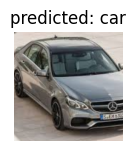

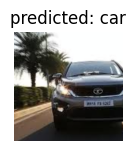

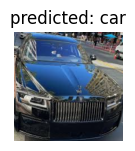

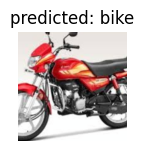

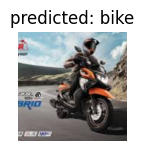

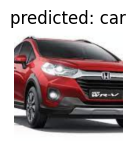

In [19]:
visualize_model(model)

plt.ioff()
plt.show()